Suggestion for virtual enviroment:
----------------------------------

(Not all are requirements for pymoode)

ipykernel\
jupyter\
matplotlib==3.5.* \
numpy==1.22.* \
scikit-learn==1.0.* \
scipy==1.8.* \
pymoo==0.5.* \
pymoode==0.1.* \
PyQt5==5.15.* \
pyrecorder==0.2.* 

# Import packages

In [2]:
#Useful packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize as moo_minimize

In [4]:
#Algorithmss
from pymoode.de import DE
from pymoode.nsde import NSDE
from pymoode.gde3 import GDE3
from pymoode.nsder import NSDER
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

#Reference directions and test problems
from pymoo.factory import get_reference_directions, get_problem

#Survival operators
from pymoode.survivors import RankSurvival, ConstrainedRankSurvival

In [5]:
#Termination
from pymoo.util.termination.default import SingleObjectiveDefaultTermination, MultiObjectiveDefaultTermination

In [6]:
#Performance
from pymoo.factory import get_performance_indicator

In [7]:
#Recorder
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
from pyrecorder.writers.gif import GIF
from pyrecorder.converters.matplotlib import Matplotlib

# Defining a problem

**Rastrigin:**

$f(\boldsymbol{x}) = An + \sum_{i=1}^{n}[\boldsymbol{x}_i^2 - A \, \mathrm{cos}(2 \pi \boldsymbol{x}_i)]$

In [8]:
#Defining the objective function
def rastrigin(x):
    return np.sum(x * x - 10 * np.cos(2 * np.pi * x)) + 10 * np.size(x)

#Functional
functional_problem_1 = FunctionalProblem(n_var=2, objs=rastrigin,
                                         xl=np.full(2, -5.12), xu=np.full(2, 5.12),
                                         constr_ieq=[])

class ElementwiseF1(ElementwiseProblem):

    def __init__(self):
        
        xl = np.full(2, -5.12)
        xu = np.full(2, 5.12)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = rastrigin(x)

class ProblemF1(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.12)
        xu = np.full(2, 5.12)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        out["F"] = np.sum(x * x - 10 * np.cos(2 * np.pi * x), axis=1) + 10 * x.shape[1]

# Single-objective DE

In [9]:
de = DE(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7)

In [10]:
NGEN = 100
SEED = 12

In [11]:
termination_1 = SingleObjectiveDefaultTermination(
    x_tol=1e-6,
    cv_tol=0.0,
    f_tol=1e-6,
    nth_gen=5,
    n_last=10,
    n_max_gen=NGEN)

In [12]:
%%time
res_de_functional_1 = moo_minimize(functional_problem_1,
                                   de,
                                   termination=termination_1,
                                   seed=SEED,
                                   save_history=True,
                                   verbose=False)

print(f"f: {(res_de_functional_1.F[0]):.4f}")
print(f"x_opt: {(res_de_functional_1.X)}")

f: 0.0000
x_opt: [4.09270298e-06 6.71213894e-07]
CPU times: total: 625 ms
Wall time: 691 ms


In [13]:
%%time
res_de_elementwise_1 = moo_minimize(ElementwiseF1(),
                                    de,
                                    termination=termination_1,
                                    seed=SEED,
                                    save_history=True,
                                    verbose=False)

print(f"f: {(res_de_elementwise_1.F[0]):.4f}")
print(f"x_opt: {(res_de_elementwise_1.X)}")

f: 0.0000
x_opt: [4.09270298e-06 6.71213894e-07]
CPU times: total: 484 ms
Wall time: 542 ms


In [14]:
%%time
res_de_problem_1 = moo_minimize(ProblemF1(),
                                de,
                                termination=termination_1,
                                seed=SEED,
                                save_history=True,
                                verbose=False)

print(f"f: {(res_de_problem_1.F[0]):.4f}")
print(f"x_opt: {(res_de_problem_1.X)}")

f: 0.0000
x_opt: [4.09270298e-06 6.71213894e-07]
CPU times: total: 359 ms
Wall time: 437 ms


In [15]:
#Creating a countouf plot
x1 = np.linspace(-5.12, 5.12, 100)
x2 = np.linspace(-5.12, 5.12, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([rastrigin(x) for x in X.T])
F = F.reshape([100, 100])

In [16]:
def make_ordinal(n):
    n = int(n)
    suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    return str(n) + suffix

In [17]:
writer = GIF("../images/soo_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(min(50, len(res_de_functional_1.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

        surf = ax.contourf(X1, X2, F, levels=40)
        fig.colorbar(surf, shrink=1.0, aspect=20)

        ax.scatter(res_de_functional_1.history[g].pop.get("X")[:, 0],
                   res_de_functional_1.history[g].pop.get("X")[:, 1],
                   marker="x", color="red", label="Population")
        ax.legend(framealpha=1.0)

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))

        plt.tight_layout()
        
        rec.record()

# Multi-objective problem

$f_1(\boldsymbol{x}) = (\boldsymbol{x}_1 - 0.5) ^ 2 + 0.7 \boldsymbol{x}_1 \boldsymbol{x}_2 + 1.2 (\boldsymbol{x}_2 + 0.7) ^ 2$

$f_2(\boldsymbol{x}) = (\boldsymbol{x}_1 + 1.5) ^ 2 + 0.8 \boldsymbol{x}_1 \boldsymbol{x}_2 + 1.3 (\boldsymbol{x}_2 - 1.7) ^ 2$

$g_1(\boldsymbol{x}) = \boldsymbol{x}_1 ^ 2 + (\boldsymbol{x}_2 - 1) ^ 2 - 9 \leq 0$

$g_2(\boldsymbol{x}) = (\boldsymbol{x}_1 + 0.5) ^ 2 + (\boldsymbol{x}_2 - 1) ^ 2 + 2 \leq 0$

In [18]:
class ProblemF2(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=1, n_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        F1 = (x[:, 0] - 0.5) ** 2 + 0.7 * x[:, 0] * x[:, 1] + 1.2 * (x[:, 1] + 0.7) ** 2
        
        F2 = 1.1 * (x[:, 0] + 1.5) ** 2 + 0.8 * x[:, 0] * x[:, 1] + 1.3 * (x[:, 1] - 1.7) ** 2
        
        out["F"] = np.column_stack([F1, F2])
        
        G1 = x[:, 0] ** 2 + (x[:, 1] - 1) ** 2 - 9
        G2 = - (x[:, 0] + 0.5) ** 2 - (x[:, 1] - 1) ** 2 + 2
        
        out["G"] = np.column_stack([G1, G2])

In [19]:
#Using a not so large value for CR due to the low dimensionality of the problem
nsde = NSDE(pop_size=30, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.7)
gde3 = GDE3(pop_size=30, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.5)
nsga2 = NSGA2(pop_size=30)

In [20]:
%matplotlib inline

In [21]:
NGEN = 200

In [22]:
termination_multi = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-8,
    f_tol=1e-8,
    nth_gen=5,
    n_last=50,
    n_max_gen=NGEN,
)

In [23]:
res_nsde_problem_2 = moo_minimize(ProblemF2(),
                                  nsde,
                                  termination_multi,
                                  seed=SEED,
                                  save_history=True,
                                  verbose=False)

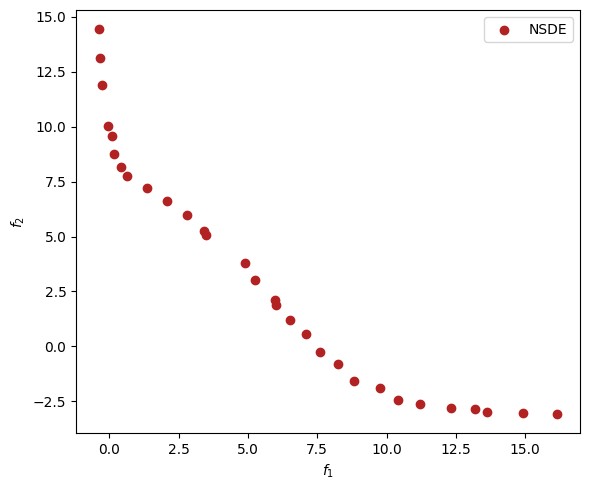

In [24]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [25]:
res_gde3_problem_2 = moo_minimize(ProblemF2(),
                                  gde3,
                                  termination_multi,
                                  seed=SEED,
                                  save_history=True,
                                  verbose=False)

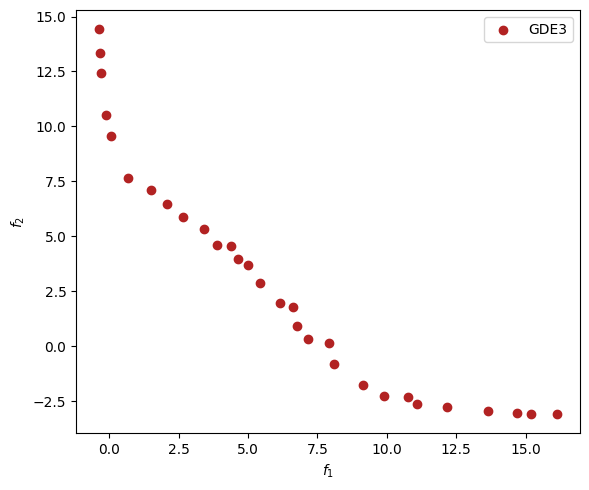

In [26]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="firebrick", label="GDE3")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [27]:
res_nsga2_problem_2 = moo_minimize(ProblemF2(),
                                   nsga2,
                                   termination_multi,
                                   seed=SEED,
                                   save_history=True,
                                   verbose=False)

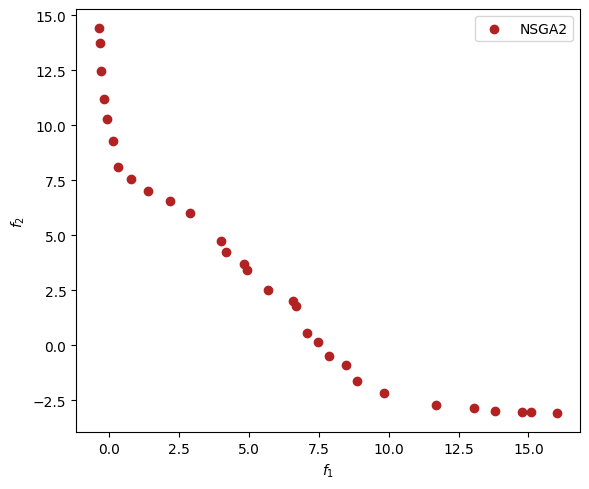

In [28]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsga2_problem_2.F[:, 0], res_nsga2_problem_2.F[:, 1], color="firebrick", label="NSGA2")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

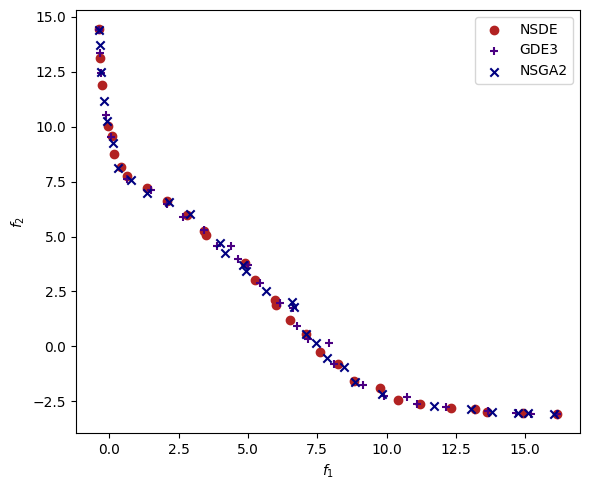

In [29]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE", marker="o")
ax.scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="indigo", label="GDE3", marker="+")
ax.scatter(res_nsga2_problem_2.F[:, 0], res_nsga2_problem_2.F[:, 1], color="navy", label="NSGA2", marker="x")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [30]:
objs_p2 = np.row_stack([res_nsde_problem_2.F, res_gde3_problem_2.F, res_nsga2_problem_2.F])
nadir_p2 = objs_p2.max(axis=0)
reference_p2 = nadir_p2 + 1e-6
ideal_p2 =  objs_p2.min(axis=0)

In [31]:
#Evaluate by Hypervolume
hv_p2 = get_performance_indicator("hv", ref_point=reference_p2, zero_to_one=True,
                                  nadir=nadir_p2, ideal=ideal_p2)

print("hv NSDE", hv_p2.do(res_nsde_problem_2.F))
print("hv GDE3", hv_p2.do(res_gde3_problem_2.F))
print("hv NSGA-II", hv_p2.do(res_nsga2_problem_2.F))

hv NSDE 0.7447080896423105
hv GDE3 0.7438915084459402
hv NSGA-II 0.7431186840607392


## Record evolution on multi-objective problems

In [32]:
writer = GIF("../images/moo_nsde_f_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(min(50, len(res_nsde_problem_2.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        ranks = res_nsde_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_nsde_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[front, 0],
                   res_nsde_problem_2.history[g].pop.get("F")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[~(front | infeasible), 0],
                   res_nsde_problem_2.history[g].pop.get("F")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[infeasible, 0],
                   res_nsde_problem_2.history[g].pop.get("F")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        ax.legend(framealpha=1.0, loc="upper right")

        ax.set_xlabel("$f_1$")
        ax.set_ylabel("$f_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([-4.0, 17])
        ax.set_xlim([-1.0, 17])

        plt.tight_layout()
        
        rec.record()

In [33]:
writer = GIF("../images/moo_nsde_x_video.gif", duration=0.3)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(min(50, len(res_nsde_problem_2.history))):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        ranks = res_nsde_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_nsde_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[front, 0],
                   res_nsde_problem_2.history[g].pop.get("X")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[~(front | infeasible), 0],
                   res_nsde_problem_2.history[g].pop.get("X")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[infeasible, 0],
                   res_nsde_problem_2.history[g].pop.get("X")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        ax.legend(framealpha=1.0, loc="upper right")

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])

        plt.tight_layout()
        
        rec.record()

## Other survival operators

In [34]:
#Rule: How to remove elements in the last front based on crowding metric
#Crowding func: Crowding metric
dyn_survival = RankSurvival(rule="sqrt", crowding_func="cd")

In [35]:
nsde_dyn = NSDE(pop_size=30, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.7, survival=dyn_survival)

In [36]:
res_dyn_nsde_problem_2 = moo_minimize(ProblemF2(),
                                      nsde_dyn,
                                      ('n_gen', NGEN),
                                      seed=SEED,
                                      save_history=True,
                                      verbose=False)

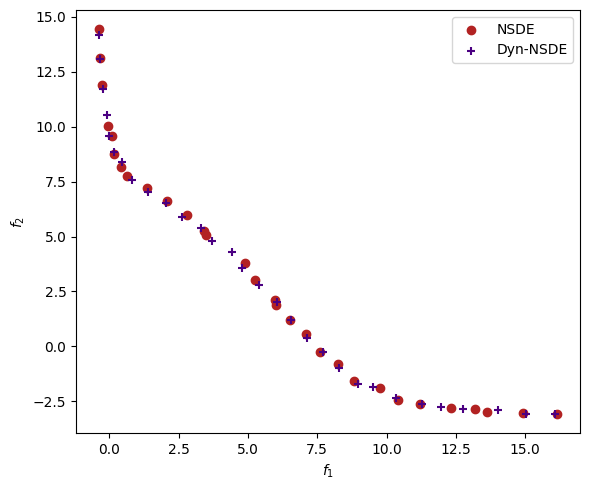

In [37]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE", marker="o")
ax.scatter(res_dyn_nsde_problem_2.F[:, 0], res_dyn_nsde_problem_2.F[:, 1], color="indigo", label="Dyn-NSDE", marker="+")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [38]:
print("hv NSDE", hv_p2.do(res_nsde_problem_2.F))
print("hv Dyn-NSDE", hv_p2.do(res_dyn_nsde_problem_2.F))

hv NSDE 0.7447080896423105
hv Dyn-NSDE 0.748206068495192


## Many-objective problem

In [39]:
#Define the reference directions
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)

#Suggestion for NSGA-III
popsize = ref_dirs.shape[0] + ref_dirs.shape[0] % 4

nsder = NSDER(ref_dirs, pop_size=popsize, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.2)
gde3mnn = GDE3(pop_size=popsize, variant="DE/rand/1/bin", F=(0.0, 1.0), CR=0.2,
               survival=RankSurvival(rule="full", crowding_func="mnn"))
nsga3 = NSGA3(ref_dirs, pop_size=popsize)

**DTLZ2:**

$f_1(\boldsymbol{x}) = \mathrm{cos}(\pi / 2 \boldsymbol{x}_1) \, \mathrm{cos}(\pi / 2 \boldsymbol{x}_2) (1 + g(\boldsymbol{x}))$

$f_2(\boldsymbol{x}) = \mathrm{cos}(\pi / 2 \boldsymbol{x}_1) \, \mathrm{sin}(\pi / 2 \boldsymbol{x}_2) (1 + g(\boldsymbol{x}))$

$f_3(\boldsymbol{x}) = \mathrm{sin}(\pi / 2 \boldsymbol{x}_1) (1 + g(\boldsymbol{x}))$

$g(\boldsymbol{x}) = \sum_{i=1}^{3}(\boldsymbol{x}_i - 0.5) ^ 2$

In [40]:
res_nsder_problem_3 = moo_minimize(get_problem("dtlz2"),
                                   nsder,
                                   ('n_gen', 250),
                                   seed=SEED,
                                   save_history=True,
                                   verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.391090068 |  0.474706560
    2 |     272 |  0.396972137 |  0.460745959
    3 |     408 |  0.352916351 |  0.436882537
    4 |     544 |  0.294835453 |  0.348225030
    5 |     680 |  0.268849291 |  0.289135967
    6 |     816 |  0.235402406 |  0.257075371
    7 |     952 |  0.213910096 |  0.218495543
    8 |    1088 |  0.183774102 |  0.200461160
    9 |    1224 |  0.165535026 |  0.186194913
   10 |    1360 |  0.157860079 |  0.155700935
   11 |    1496 |  0.145115618 |  0.149274226
   12 |    1632 |  0.136984160 |  0.135128066
   13 |    1768 |  0.125951428 |  0.113423904
   14 |    1904 |  0.118277869 |  0.101316086
   15 |    2040 |  0.104179256 |  0.093588926
   16 |    2176 |  0.103792854 |  0.090084355
   17 |    2312 |  0.096185593 |  0.082416385
   18 |    2448 |  0.090543053 |  0.079013194
   19 |    2584 |  0.087427730 |  0.075147136
   20 |    2720 |  0.083100977 |  0.067914595
   21 |    2856 |  0.076338895 |  

In [41]:
res_gde3_problem_3 = moo_minimize(get_problem("dtlz2"),
                                  gde3mnn,
                                  ('n_gen', 250),
                                  seed=SEED,
                                  save_history=True,
                                  verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.376813325 |  0.467522862
    2 |     272 |  0.357603866 |  0.462321655
    3 |     408 |  0.323833992 |  0.433401548
    4 |     544 |  0.291413700 |  0.378494106
    5 |     680 |  0.282177855 |  0.370788855
    6 |     816 |  0.250545794 |  0.344893897
    7 |     952 |  0.235969887 |  0.323333060
    8 |    1088 |  0.212102228 |  0.283914007
    9 |    1224 |  0.190211793 |  0.247909789
   10 |    1360 |  0.166698750 |  0.218235450
   11 |    1496 |  0.153138231 |  0.196652461
   12 |    1632 |  0.140084558 |  0.182358722
   13 |    1768 |  0.124959660 |  0.161923371
   14 |    1904 |  0.115586858 |  0.145401572
   15 |    2040 |  0.107782670 |  0.128296940
   16 |    2176 |  0.101175724 |  0.115478029
   17 |    2312 |  0.095094474 |  0.104960621
   18 |    2448 |  0.088930969 |  0.092986489
   19 |    2584 |  0.083213337 |  0.082735404
   20 |    2720 |  0.075255743 |  0.076810538
   21 |    2856 |  0.072678556 |  

In [42]:
res_nsga3_problem_3 = moo_minimize(get_problem("dtlz2"),
                                   nsga3,
                                   ('n_gen', 250),
                                   seed=SEED,
                                   save_history=True,
                                   verbose=True)

n_gen |  n_eval |     igd      |      gd     
    1 |     136 |  0.514657789 |  0.553619682
    2 |     272 |  0.456114447 |  0.492254607
    3 |     408 |  0.382565460 |  0.405462313
    4 |     544 |  0.335576065 |  0.378042745
    5 |     680 |  0.236051126 |  0.310143016
    6 |     816 |  0.274536664 |  0.274041092
    7 |     952 |  0.221712399 |  0.290487797
    8 |    1088 |  0.213213140 |  0.201015075
    9 |    1224 |  0.181351751 |  0.181507296
   10 |    1360 |  0.147768274 |  0.157442091
   11 |    1496 |  0.129990703 |  0.141160530
   12 |    1632 |  0.125885889 |  0.127653034
   13 |    1768 |  0.112731099 |  0.116635040
   14 |    1904 |  0.104144483 |  0.098189069
   15 |    2040 |  0.095564520 |  0.089910256
   16 |    2176 |  0.092506349 |  0.087975729
   17 |    2312 |  0.084558024 |  0.076649421
   18 |    2448 |  0.079693233 |  0.070196776
   19 |    2584 |  0.073449334 |  0.066762152
   20 |    2720 |  0.069845792 |  0.061537083
   21 |    2856 |  0.063660505 |  

In [43]:
#%matplotlib qt

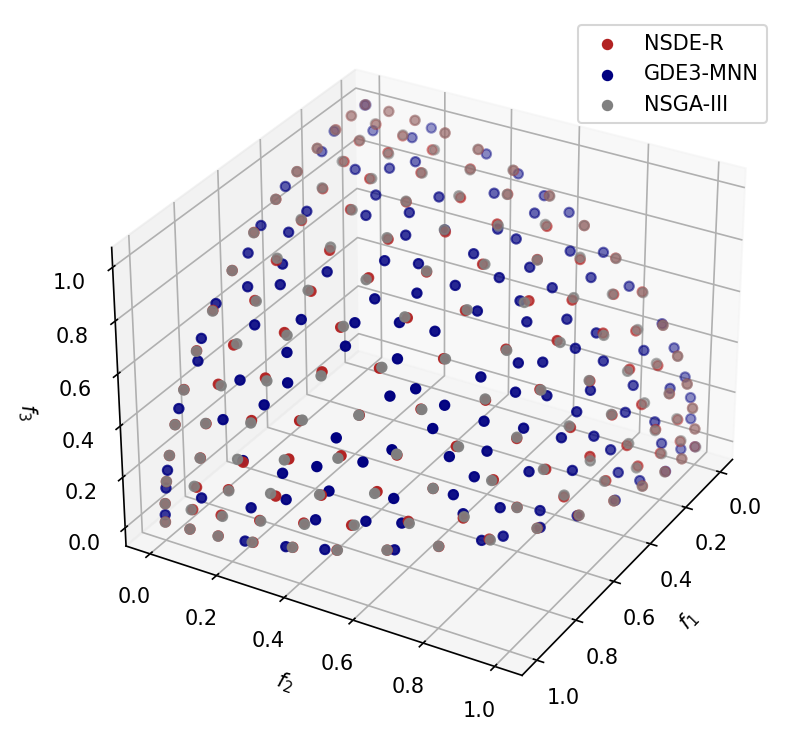

In [44]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})

ax.scatter(res_nsder_problem_3.F[:, 0], res_nsder_problem_3.F[:, 1], res_nsder_problem_3.F[:, 2],
        color="firebrick", label="NSDE-R", marker="o")

ax.scatter(res_gde3_problem_3.F[:, 0], res_gde3_problem_3.F[:, 1], res_gde3_problem_3.F[:, 2],
        color="navy", label="GDE3-MNN", marker="o")

ax.scatter(res_nsga3_problem_3.F[:, 0], res_nsga3_problem_3.F[:, 1], res_nsga3_problem_3.F[:, 2],
        color="grey", label="NSGA-III", marker="o")

ax.view_init(elev=30, azim=30)

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
fig.tight_layout()

In [45]:
writer = GIF("../images/3d_many_obj_video.gif", duration=0.1)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:

    for azim in np.linspace(30, 390, 120):
        
        fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={'projection':'3d'})
        
        ax.scatter(res_nsder_problem_3.F[:, 0], res_nsder_problem_3.F[:, 1], res_nsder_problem_3.F[:, 2],
                color="firebrick", label="NSDE-R", marker="o")
        
        ax.scatter(res_gde3_problem_3.F[:, 0], res_gde3_problem_3.F[:, 1], res_gde3_problem_3.F[:, 2],
                color="navy", label="GDE3-MNN", marker="o")

        ax.scatter(res_nsga3_problem_3.F[:, 0], res_nsga3_problem_3.F[:, 1], res_nsga3_problem_3.F[:, 2],
                color="grey", label="NSGA-III", marker="o")
        
        ax.view_init(elev=25, azim=azim)

        ax.set_xlabel("$f_1$")
        ax.set_ylabel("$f_2$")
        ax.set_zlabel("$f_3$")
        ax.legend()
        fig.tight_layout()
        
        rec.record()